# Scenario

## Scenario 1: Pre Development model, no seasonality

Build the base model as described above without the proposed agricultural activity.
 * Run the model as steady state with no pumping from the town's well.
 * Calculate the flux from the stream to the groundwater
 * Also show a reverse particle track map to identify the source of the water to the stream.
 * Finally, report the water level at the monitoring wells and at the town's well (even though it isn't pumping for this scenario).

# Import

In [1]:
import flopy
import numpy as np
import matplotlib as mp
import os
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv
%matplotlib inline

flopy is installed in C:\Users\vivek\Anaconda3\lib\site-packages\flopy


# Domain

In [2]:
## Discretization in x/y
nrow = 50
ncol = 50

dx = 1000 #width of one grid cell in x-dir (m)
dy = 1000 #width of one grid cell in y-dir (m)

Lx = ncol * dx #Total length of domain in x
Ly = nrow * dy #Total length of domain in y

## Discretization in z
nlay = 3
ztop=np.genfromtxt('base_model_elevs.csv',delimiter=',',dtype=float) #import "dem"
ztop[0,0]=125 #is this the missing initial value

zbot=np.zeros((nlay,nrow,ncol)) #bottom of domain is zero
zbot[1,:,:]=40 #bottom of middle layer
zbot[0,:,:]=45 #bottom of top layer

##Static hydrogeologic variables 
n = 0.1
Sy = 0.1
Ss = 1e-4
hka = 10 #this is the horizontal k for top, middle and bottom 
vka = 10 #vertical k for horizontal k for top, bottom, and left 20 cols for middle
vka_mid = 0.0001 #vertical k for right 30 cols

## Make a arrays for the K values
#Set horizontal K
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = hka                 # assign the original value to the entire array

#set vertical K
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = vka                   # assign the original value to the entire array
Kz[1,:,20:] = vka_mid                 #Replace the K in the middle layer with the lower value

RCB_head = 70
nper=1
nstp=1
steady=[True]

##Setting no flow triangles
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

#Setting up Recharge
recharge_zone = np.zeros((1,nrow,ncol)) # define an array of zeros the size of the model grid

rech1 = 4e-5 # m/day
rech_llxy = [0,0]  # lower left xy coords
rech_urxy = [15000,50000] # upper right xy coords
##convert to rows and columns
rech_rowll = int(np.floor((nrow-1)-(rech_llxy[1]/dy))) #convert the y location to a row
rech_colll=int(np.floor(rech_llxy[0]/dx))          #convert the x location to a column
rech_rowur = int(np.floor((nrow)-(rech_urxy[1]/dy))) #convert the y location to a row
rech_colur=int(np.floor(rech_urxy[0]/dx))          #convert the x location to a column
#print(rech_colll, rech_rowll, rech_colur, rech_rowur)

recharge_zone[0,rech_rowur:rech_rowll, rech_colll:rech_colur] = rech1


# Setting up ET
ET_zone = np.zeros((1,nrow,ncol))#ET in left half of domain is zero
ET_right = 1e-5 #m/day ET over right of domain
ET_rip =5e-5 #ET in riparian area
extinction_depth = 10 #10m everywhere

ET_right_llxy = [25000,0] #lower left corner xy for right half ET zone
ET_right_urxy = [50000,50000]
##convert to rows and columns
ET_right_rowll = int(np.floor((nrow-1)-(ET_right_llxy[1]/dy))) #convert the y location to a row
ET_right_colll=int(np.floor(ET_right_llxy[0]/dx))          #convert the x location to a column
ET_right_rowur = int(np.floor((nrow)-(ET_right_urxy[1]/dy))) #convert the y location to a row
ET_right_colur=int(np.floor(ET_right_urxy[0]/dx))          #convert the x location to a column
print(ET_right_colll, ET_right_rowll, ET_right_colur, ET_right_rowur)

ET_zone[0,ET_right_rowur:ET_right_rowll, ET_right_colll:ET_right_colur] = ET_right


ET_rip_llxy = [0,23000]#lower left corner xy for riparian strip
ET_rip_urxy = [50000,29000]
##convert to rows and columns
ET_rip_rowll = int(np.floor((nrow-1)-(ET_rip_llxy[1]/dy))) #convert the y location to a row
ET_rip_colll=int(np.floor(ET_rip_llxy[0]/dx))          #convert the x location to a column
ET_rip_rowur = int(np.floor((nrow)-(ET_rip_urxy[1]/dy))) #convert the y location to a row
ET_rip_colur=int(np.floor(ET_rip_urxy[0]/dx))          #convert the x location to a column
print(ET_rip_colll, ET_rip_rowll, ET_rip_colur, ET_rip_rowur)

ET_zone[0,ET_rip_rowur:ET_rip_rowll, ET_rip_colll:ET_rip_colur] = ET_rip


# Setting up well
pumping1 = -0 # m3/day      pumping rate for water supply well  
pumping2 = -0 # m^3/d             irrigation well pumping rate (for wheat)

well_1_xy= [38000, 21000] # xy location of supply well 
well_1_row = np.floor((nrow-1)-(well_1_xy[1]/dy)) #convert the y location to a row (python row)
well_1_col=np.floor(well_1_xy[0]/dx-1) #convert the x location to a column
well_1_loc = [2,well_1_row,well_1_col] #Well loc (layer, row, column)

well_2_xy= [14000, 12000] # xy location of irrigation well 
well_2_row = np.floor((nrow-1)-(well_2_xy[1]/dy)) #convert the y location to a row 
well_2_col=np.floor(well_2_xy[0]/dx-1) #convert the x location to a column
well_2_loc = [0,well_2_row,well_2_col] #Well loc (layer, row, column)

MW1_xy =[25000, 25000] # xy location of monitoring well 1 
MW1_row = np.floor((nrow-1)-(MW1_xy[1]/dy))  
MW1_col=np.floor(MW1_xy[0]/dx-1) 
MW1_loc = [0,MW1_row,MW1_col] 

MW2_xy = [12500, 12500] # xy location of smonitoring well 2 
MW2_row = np.floor((nrow-1)-(MW2_xy[1]/dy)) 
MW2_col=np.floor(MW2_xy[0]/dx-1) 
MW2_loc = [0,MW2_row,MW2_col] 
    
# #DEFINE RIVERS
# riv_row= 25
# riv_sp = [] #create list to store all river cells for stress period 1
# k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
# sed_thick = 1 #thickness of riverbed sediment in m
# cond = k_rivbott*(dy)*(dx)/(sed_thick) #river bed conductance in m^2/d
# r_stage = 0.5 #stage in river (stress period 1)
# r_bott = ztop[25,:] #river bottom
# #print(r_bott)
# for i in range(1,ncol):
#     riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
# #print(riv_spd)
# #create dictionary of stress period data
# riv_spd = {0: riv_sp}
# #print(riv_spd)    
    

25 49 50 0
0 26 50 21


# Setup and Run MODFLOW

In [3]:
#Initialize the model
modelname = "Scenario_1_2"
moddir="C:\WRDAPP\MODFLOW\mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# Boundary and initial conditions - bas
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #as 1 everywhere 
H_init[:, :, ncol-1] = RCB_head    #right boundary to 70
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=recharge_zone, ipakcb=53)     #create rch object

#ET:
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 

#Setting up Wells

well_1 = [i for i in well_1_loc] + [pumping1]
print("Well 1 [layer, row, column, flux]: \n", well_1)
well_2 = [i for i in well_2_loc] + [pumping2]
print("Well 2 [layer, row, column, flux]: \n", well_2)
Mwell_1 = [i for i in MW1_loc] + [0]
print("Monitoring Well 1 [layer, row, column, flux]: \n", Mwell_1)
Mwell_2 = [i for i in MW2_loc] + [0]
print("Monitoring Well 2 [layer, row, column, flux]: \n", Mwell_2)


wel_spd = {0: [well_1, well_2, Mwell_1, Mwell_2]}
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

    
    
# #attach river package
# riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd, ipakcb=53)

spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m)

#write the inputs
m.write_input()    

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

Well 1 [layer, row, column, flux]: 
 [2, 28.0, 37.0, 0]
Well 2 [layer, row, column, flux]: 
 [0, 37.0, 13.0, 0]
Monitoring Well 1 [layer, row, column, flux]: 
 [0, 24.0, 24.0, 0]
Monitoring Well 2 [layer, row, column, flux]: 
 [0, 36.0, 11.0, 0]
FloPy is using the following  executable to run the model: C:\WRDAPP\MODFLOW\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Scenario_1_2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/16 16:34:25

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/04/16 16:34:25
 Elapsed run time:  0.284 Seconds

  Normal termination of simulation


# Plotting the domain

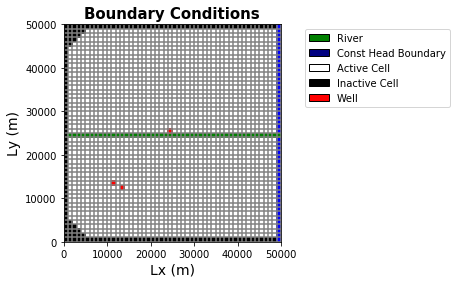

In [4]:
#CHECK BOUNDARY CONDITIONS
#use flopy to plot grid, ibound, rivers, and general head boundaries
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()

#ET = modelmap.plot_array(ET_zone)
# #recharge = modelmap.plot_array(recharge_zone)
# riv_plot = modelmap.plot_bc(ftype='RIV')
wel_plot = modelmap.plot_bc(ftype='WEL')

#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Boundary Conditions', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'),
                   mp.patches.Patch(color='navy',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   mp.patches.Patch(color='Red',label='Well',ec='black')],
                   bbox_to_anchor=(1.8,1.0))


# Adding the Particles

In [5]:
moddirmp="C:\WRDAPP\modpath_7_2_001\mpath7"
mpname=os.path.join(modelname + '_mp')


locsb = [[0, 0, 0, 0, nrow - 1, ncol-1]]
#set the number of particles per cell
sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=1, rowcelldivisions=1, layercelldivisions=1)
#setup theparticles
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb])
pg2 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg2]

defaultiface = {'RECHARGE': 6, 'ET': 6}

#setup  the modpath packages
mp = flopy.modpath.Modpath7(modelname=modelname + '_mp', flowmodel=m, exe_name=moddirmp)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=n, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='extend', 
                                  particlegroups= particlegroups)

mp.add_package(rch)
# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

mp.get_package_list()

FloPy is using the following  executable to run the model: C:\WRDAPP\modpath_7_2_001\mpath7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compiler (ver. 16.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
      2334 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


['MPBAS', 'MPSIM', 'RCH']

# Reading the outputs

In [6]:
#extract binary data from head file
times = [0] #extract times at end of each stress period
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period
storage = {} #create dictionary to store storage at end of each stress period
consthead = {} #create dictionary to store constant head boundary at end of each stress period
leakage = {} #create dictionary to store leakage at end of each stress period

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

# with open('FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
#     writer = csv.writer(csvfile, delimiter=',')        
#     for i in range(len(head[0,:,0])):                    #writes each row
#         writer.writerow(head[0,i,:])

#get data from python objects
head = headobj.get_data(totim=1.0) #append heads to head list for ea stress per
frf = budgobj.get_data(text='FLOW RIGHT FACE',totim=1.0) #append right face flow to frf list for ea stress per
fff = budgobj.get_data(text='FLOW FRONT FACE',totim=1.0) #append front face flow to fff list for ea stress per
#storage = budgobj.get_data(text='STORAGE',totim=1.0) #append front face flow to fff list for ea stress per
consthead = budgobj.get_data(text='CONSTANT HEAD',totim=1.0) #append front face flow to fff list for ea stress per
leakage = budgobj.get_data(text='RIVER LEAKAGE',totim=1.0) #append front face flow to fff list for ea stress per

print(leakage)

[rec.array([(1252, 0.), (1253, 0.), (1254, 0.), (1255, 0.), (1256, 0.),
           (1257, 0.), (1258, 0.), (1259, 0.), (1260, 0.), (1261, 0.),
           (1262, 0.), (1263, 0.), (1264, 0.), (1265, 0.), (1266, 0.),
           (1267, 0.), (1268, 0.), (1269, 0.), (1270, 0.), (1271, 0.),
           (1272, 0.), (1273, 0.), (1274, 0.), (1275, 0.), (1276, 0.),
           (1277, 0.), (1278, 0.), (1279, 0.), (1280, 0.), (1281, 0.),
           (1282, 0.), (1283, 0.), (1284, 0.), (1285, 0.), (1286, 0.),
           (1287, 0.), (1288, 0.), (1289, 0.), (1290, 0.), (1291, 0.),
           (1292, 0.), (1293, 0.), (1294, 0.), (1295, 0.), (1296, 0.),
           (1297, 0.), (1298, 0.), (1299, 0.), (1300, 0.)],
          dtype=[('node', '<i4'), ('q', '<f4')])]


# Reading the particle files 

In [7]:
#load in the flow path file
fpth = os.path.join(mpname + '.mppth')
p = flopy.utils.PathlineFile(fpth)

#load in the end point file
fpth = os.path.join(mpname + '.mpend')
e = flopy.utils.EndpointFile(fpth, verbose=False)

#make a subset which is all the particles
pall = p.get_alldata()  #formerly pwb and ewb
eall = e.get_alldata()

#make a subset which is the partlces that end in the well 
rivernodes = list(range(1301, 1350))
#print(rivernodes)
priver = p.get_destination_pathline_data(dest_cells=rivernodes)
eriver= e.get_destination_endpoint_data(dest_cells=rivernodes)

# Plotting Flowlines

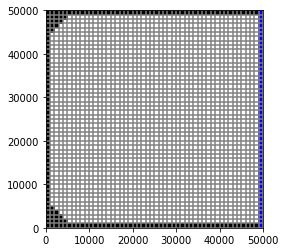

In [8]:
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()

modelmap.plot_pathline(pall, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by wells') #,marker='o', markercolor='black', markersize=3, markerevery=5)
modelmap.plot_pathline(priver, layer='all', color='green', lw=0.5, linestyle=':', label='captured by well') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
plt.show(modelmap)



# Plotting Heads

In [9]:
#Checking heads at the wells

print("Head at Monitoring Well 1 = ", head[0, int(MW1_row), int(MW2_col)])
print("Head at Monitoring Well 2 = ", head[0, int(MW2_row), int(MW2_col)])
print("Head at Community Well 1 = ", head[2, int(well_1_row), int(well_1_col)])


Head at Monitoring Well 1 =  -1e+30
Head at Monitoring Well 2 =  -1e+30
Head at Community Well 1 =  75.998695


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[ -0.       45.10432  68.54664  93.12805 118.49098 144.67108 171.7765
 199.91066 229.14209 259.48514 290.88977 323.2469  356.40918 390.21695
 424.51877 419.18402 414.107   409.20645 404.42224 399.7114  395.04382
 390.39886 385.76202 381.1221  376.4683  365.26813 354.82864 345.10004
 336.0392  327.60974 319.78088 312.5252  305.81815 299.6371  294.01535
 288.65002 283.59717 278.85974 274.4435  270.36087 266.62488 263.24915
 260.24817 257.63718 255.43132 253.64525 252.2923  251.38356 250.9271
   0.     ]


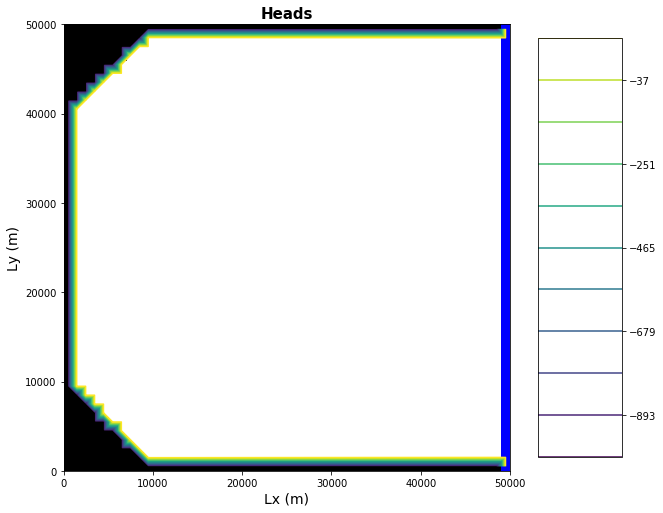

In [10]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
print(fff[0][0][40])
print(frf[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m, layer=2) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0][0].min(),head[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
#flows = modelmap.plot_discharge(frf1[0][0], fff1[0][0], head=head1[0]) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Heads', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   